#Habitat-sim Basics for Navigation

The Habitat platform relies on a number of key abstractions that model the domain of embodied agents and tasks that can be carried out in three-dimensional indoor simulation environments.

- **Agent**: a virtually embodied agent (e.g., a robot) with a suite of Sensors. Can observe the environment and is capable of taking actions that change agent or environment state.
- **Sensor**: associated with a specific Agent, capable of returning observation data from the environment at a specified frequency.
- **Scene**: a 3D environment containing a scene mesh, objects, Agents, and Sensors.
- **SceneGraph**: a hierarchical representation of a Scene that organizes the environment into regions and objects. Can be programmatically manipulated. All Scene components are present on the SceneGraph.
- **Simulator**: an instance of a simulator backend. Given actions for a set of configured Agents and SceneGraphs, can update the state of the Agents and SceneGraphs, and provide observations for all active Sensors possessed by the Agents.

This tutorial covers the basics of using Habitat-sim for navigation tasks, including:
- configuration of a Simulator, Sensors, and Agents.
- taking actions and retrieving observations
- pathfinding and navigation on the NavMesh

In [1]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import math
import os
import random
import sys

import git
import imageio
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

# %cd /content/habitat-sim
#
# if "google.colab" in sys.modules:
#     # This tells imageio to use the system FFMPEG that has hardware acceleration.
#     os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
#
# repo = git.Repo(".", search_parent_directories=True)
# dir_path = repo.working_tree_dir
# %cd $dir_path
# data_path = os.path.join(dir_path, "data")
# # @markdown Optionally configure the save path for video output:
# output_directory = "examples/tutorials/nav_output/"  # @param {type:"string"}
# output_path = os.path.join(dir_path, output_directory)
# if not os.path.exists(output_path):
#     os.mkdir(output_path)

# "Hello, World!"

Habitat simulator for navigation consists of **3** important concepts:
- configurable embodied agents
- multiple sensors
- Scene: generic 3D dataset handling (e.g., Matterport, Gibson, and Replica datasets).

In the 1st example, we demonstrate how to setup 1 agent with only 1 sensor (RGB visual sensor), place it in a scene, instruct it to navigate and collect the observations.

### Basic settings

To begin with, we specify a scene we are going to load, designate a default agent, and describe a couple of basic sensor parameters, such as the type, position, resolution of the obeservation (width and height).

In [2]:
# This is the scene we are going to load.
# we support a variety of mesh formats, such as .glb, .gltf, .obj, .ply
test_scene = "/home/carlos/repositorios/habitat-sim/data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"

sim_settings = {
    "scene": test_scene,  # Scene path
    "default_agent": 0,  # Index of the default agent
    "sensor_height": 1.5,  # Height of sensors in meters, relative to the agent
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
}

### Configurations for the simulator

To run the simulator, we need to create a configuration that are understandable by our simulator.\
Such a configuration consists of **2** parts:
- **One for the simulator backend.** It specifies parameters that are required to start and run the simulator. For example, the scene to be loaded, whether to load the semantic mesh, to enable physics or not. (Details: [code](https://github.com/facebookresearch/habitat-sim/blob/5820e1adc3ab238d2f564241d4705da5755542c9/src/esp/sim/Simulator.h#L44))
- **One for the agent.** It describes parameters to initialize an agent, such as height, mass, as well as the configs for the attached sensors. User can also define the amount of displacement e.g., in a forward action and the turn angle.
(Details: [code](https://github.com/facebookresearch/habitat-sim/blob/5820e1adc3ab238d2f564241d4705da5755542c9/src/esp/agent/Agent.h#L52))

In [3]:
# This function generates a config for the simulator.
# It contains two parts:
# one for the simulator backend
# one for the agent, where you can attach a bunch of sensors
def make_simple_cfg(settings):
    # simulator backend
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.scene_id = settings["scene"]

    # agent
    agent_cfg = habitat_sim.agent.AgentConfiguration()

    # In the 1st example, we attach only one sensor,
    # a RGB visual sensor, to the agent
    rgb_sensor_spec = habitat_sim.CameraSensorSpec()
    rgb_sensor_spec.uuid = "color_sensor"
    rgb_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    rgb_sensor_spec.resolution = [settings["height"], settings["width"]]
    rgb_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]

    agent_cfg.sensor_specifications = [rgb_sensor_spec]

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


cfg = make_simple_cfg(sim_settings)

### Create a simulator instance

In [ ]:
try:  # Needed to handle out of order cell run in Colab
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

### Initialize the agent

After we initialize the simulator, we could put the agent in the scene, set and query its state, such as position and orientation.

In [5]:
# initialize an agent
agent = sim.initialize_agent(sim_settings["default_agent"])

# Set agent state
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([-0.6, 0.0, 0.0])  # in world space
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

agent_state: position [-0.6  0.   0. ] rotation quaternion(1, 0, 0, 0)


### Navigate and see

In [6]:
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

Discrete action space:  ['move_forward', 'turn_left', 'turn_right']
action:  turn_right


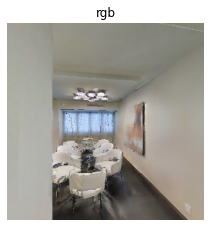

action:  turn_right


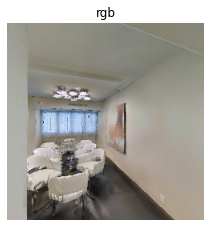

action:  move_forward


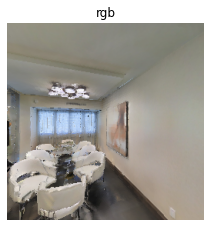

action:  turn_left


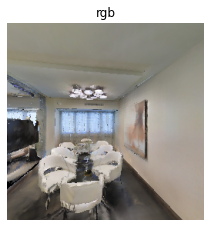

In [7]:
# obtain the default, discrete actions that an agent can perform
# default action space contains 3 actions: move_forward, turn_left, and turn_right
action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())
print("Discrete action space: ", action_names)


def navigateAndSee(action=""):
    if action in action_names:
        observations = sim.step(action)
        print("action: ", action)
        if display:
            display_sample(observations["color_sensor"])


action = "turn_right"
navigateAndSee(action)

action = "turn_right"
navigateAndSee(action)

action = "move_forward"
navigateAndSee(action)

action = "turn_left"
navigateAndSee(action)

# action = "move_backward"   // #illegal, no such action in the default action space
# navigateAndSee(action)

### Take away and look ahead

- **The basics of Habitat-Sim**: config and start the simulator, load a scene, setup an agent with a sensor, instruct the agent to navigate and see, obtain the observations.
- In the following section, we will present a comprehensive example to demonstrate:
    - **different types of sensors** ("rgb", "semantic", "depth" etc.) and their configurations
    - **the semantic scene**, and its annotation information
    - how to define and config the **action space**

#How to Take your ~~Dragon~~ [Agent] for a (Random) Walk

In [8]:
# @title Configure Sim Settings

test_scene = "/home/carlos/repositorios/habitat-sim/data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"

rgb_sensor = True  # @param {type:"boolean"}
depth_sensor = True  # @param {type:"boolean"}
semantic_sensor = True  # @param {type:"boolean"}

sim_settings = {
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
    "scene": test_scene,  # Scene path
    "default_agent": 0,
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": 1,  # used in the random navigation
    "enable_physics": False,  # kinematics only
}

In [9]:
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensor_specs = []

    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(color_sensor_spec)

    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(depth_sensor_spec)

    semantic_sensor_spec = habitat_sim.CameraSensorSpec()
    semantic_sensor_spec.uuid = "semantic_sensor"
    semantic_sensor_spec.sensor_type = habitat_sim.SensorType.SEMANTIC
    semantic_sensor_spec.resolution = [settings["height"], settings["width"]]
    semantic_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    semantic_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(semantic_sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [10]:
cfg = make_cfg(sim_settings)
# Needed to handle out of order cell run in Colab
try:  # Got to make initialization idiot proof
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

I0126 14:30:12.246973 1765 simulator.py:221] Loaded navmesh /home/carlos/repositorios/habitat-sim/data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.navmesh


In [11]:
def print_scene_recur(scene, limit_output=10):
    print(
        f"House has {len(scene.levels)} levels, {len(scene.regions)} regions and {len(scene.objects)} objects"
    )
    print(f"House center:{scene.aabb.center} dims:{scene.aabb.sizes}")

    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return


# Print semantic annotation information (id, category, bounding box details)
# about levels, regions and objects in a hierarchical fashion
scene = sim.semantic_scene
print_scene_recur(scene)

House has 1 levels, 10 regions and 187 objects
House center:[-2.7928104  1.3372791 -1.5051247] dims:[17.57338    2.9023619  8.8595495]
Level id:0, center:[-3.1573648  1.33728   -1.5051247], dims:[16.69967    2.90236    8.8595495]
Region id:0_0, category:bedroom, center:[-8.821845   1.2594094 -2.691538 ], dims:[4.163309  2.5356622 4.2073426]
Object id:0_0_0, category:wall, center:[-8.86568    1.2817702 -2.73879  ], dims:[4.5891   2.581481 4.591819]
Object id:0_0_1, category:ceiling, center:[-8.91329  2.20326 -2.80575], dims:[4.4761996 0.7124367 4.460079 ]
Object id:0_0_2, category:misc, center:[-8.69572    1.1633401 -4.2134695], dims:[2.5021195  2.3407402  0.61950994]
Object id:0_0_3, category:curtain, center:[-10.9129      1.0454602  -2.9228697], dims:[0.49171448 2.13486    3.8549194 ]
Object id:0_0_4, category:void, center:[-8.06444    1.4491597 -1.7219999], dims:[0.6184306 1.5347226 0.8975539]
Object id:0_0_5, category:bed, center:[-8.71032    0.6567161 -2.7839994], dims:[2.0257607 1

In [12]:
# the randomness is needed when choosing the actions
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

# Set agent state
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([-0.6, 0.0, 0.0])  # world space
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

agent_state: position [-0.6  0.   0. ] rotation quaternion(1, 0, 0, 0)


action move_forward


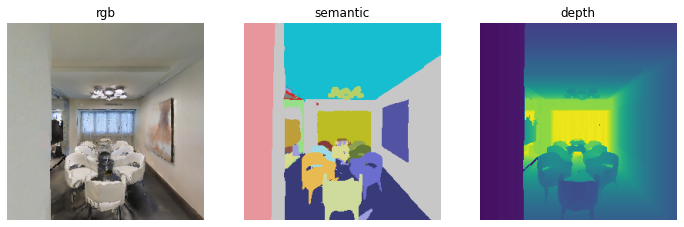

action turn_right


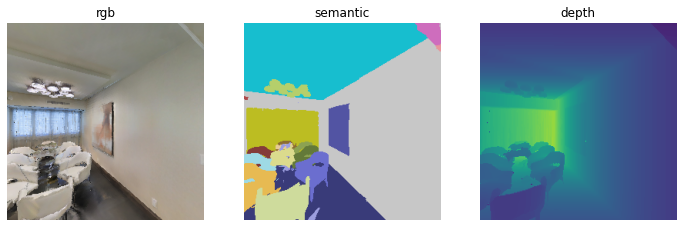

action move_forward


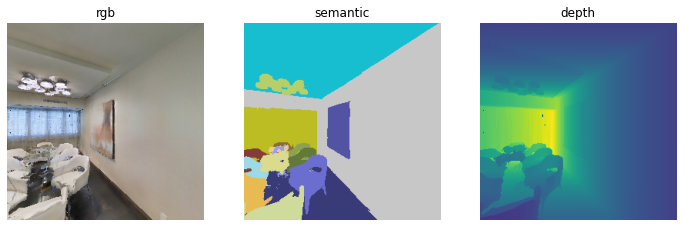

action turn_left


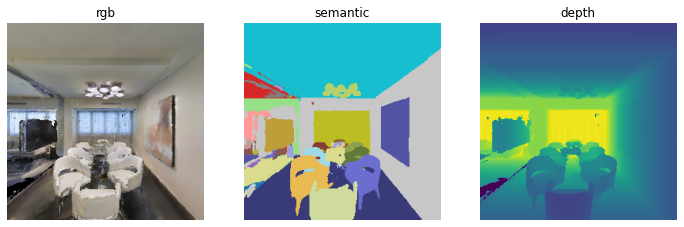

action move_forward


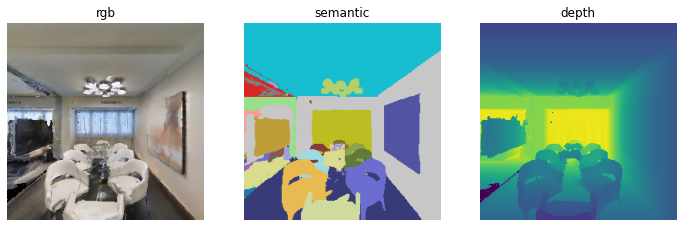

In [13]:
total_frames = 0
action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())

max_frames = 5

while total_frames < max_frames:
    action = random.choice(action_names)
    print("action", action)
    observations = sim.step(action)
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    depth = observations["depth_sensor"]

    if display:
        display_sample(rgb, semantic, depth)

    total_frames += 1

# Working with the NavMesh

### Why do we need the NavMesh?

In the previous sections, we took navigation constraints and collision response for granted. By default, this is enabled in the discrete Habitat-sim action space we demonstrated. However, when directly modifying the agent state, the agent will sense neither the obstacles nor the boundary of the scene when taking actions. We need to introduce a mechanism, light and fast, to enforce such constraints. This section will provide more details on that method

Habitat-sim provides pathfinding and navigability constraints via integration with [Recast Navigation | Detour](https://masagroup.github.io/recastdetour/) through the [nav module](https://aihabitat.org/docs/habitat-sim/habitat_sim.nav.html).

This tutorial section demonstrates loading, recomputing, and saving a NavMesh for a static scene as well as using it explicitly for discrete and continuous navigation tasks.




## What is a NavMesh?

A navigation mesh (NavMesh) is a collection of two-dimensional convex polygons (i.e., a polygon mesh) that define which areas of an environment are traversable by an agent with a particular embodiement. In other words, an agent could freely navigate around within these areas unobstructed by objects, walls, gaps, overhangs, or other barriers that are part of the environment. Adjacent polygons are connected to each other in a graph enabling efficient pathfinding algorithms to chart routes between points on the NavMesh as visualized below.
<div>
<img src="https://masagroup.github.io/recastdetour/recast_intro.png" width="300"/>
</div>

Using a NavMesh approximation of navigability, an agent is embodied as a rigid cylinder aligned with the gravity direction. The NavMesh is then computed by voxelizing the static scene and generating polygons on the top surfaces of solid voxels where the cylinder would sit without intersection or overhanging and respecting configured constraints such as maximum climbable slope and step-height.

## NavMesh utilities:

### Visualizing the NavMesh: Topdown Map

The PathFinder API makes it easy to produce a topdown map of navigability in a scene. Since the NavMesh is a 3D mesh, and scenes can have multiple floors or levels vertically, we need to slice the NavMesh at specific world height (y coordinate). The map is then generated by sampling the NavMesh at a configurable resolution (meters_per_pixel) with 0.5 meters of vertical slack.

The following example cell defines a matplotlib function to display a top down map with optional key points overlay. It then generates a topdown map of the current scene using the minimum y coordinate of the scene bounding box as the height, or an optionally configured custom height. Note that this height is in scene global coordinates, so we cannot assume that 0 is the bottom floor.

The NavMesh bounds are: (array([-11.59344 ,  -0.127553,  -5.392021], dtype=float32), array([4.757026, 4.278783, 2.88662 ], dtype=float32))
Displaying the raw map from get_topdown_view:


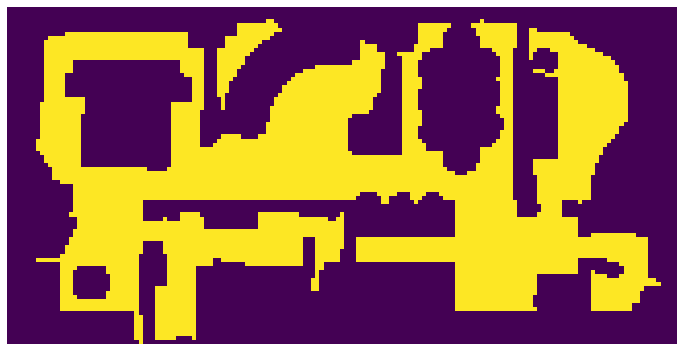

Displaying the map from the Habitat-Lab maps module:


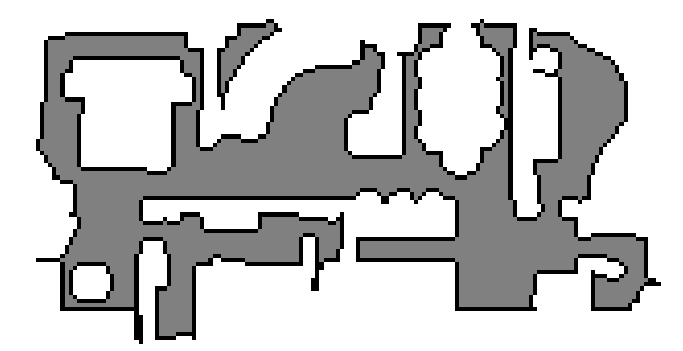

In [14]:
from habitat.utils.visualizations import maps
output_path = './data/'

# convert 3d points to 2d topdown coordinates
def convert_points_to_topdown(pathfinder, points, meters_per_pixel):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)


# @markdown ###Configure Example Parameters:
# @markdown Configure the map resolution:
meters_per_pixel = 0.1  # @param {type:"slider", min:0.01, max:1.0, step:0.01}
# @markdown ---
# @markdown Customize the map slice height (global y coordinate):
custom_height = False  # @param {type:"boolean"}
height = 1  # @param {type:"slider", min:-10, max:10, step:0.1}
# @markdown If not using custom height, default to scene lower limit.
# @markdown (Cell output provides scene height range from bounding box for reference.)

print("The NavMesh bounds are: " + str(sim.pathfinder.get_bounds()))
if not custom_height:
    # get bounding box minumum elevation for automatic height
    height = sim.pathfinder.get_bounds()[0][1]

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    # @markdown You can get the topdown map directly from the Habitat-sim API with *PathFinder.get_topdown_view*.
    # This map is a 2D boolean array
    sim_topdown_map = sim.pathfinder.get_topdown_view(meters_per_pixel, height)

    if display:
        # @markdown Alternatively, you can process the map using the Habitat-Lab [maps module](https://github.com/facebookresearch/habitat-lab/blob/main/habitat/utils/visualizations/maps.py)
        hablab_topdown_map = maps.get_topdown_map(
            sim.pathfinder, height, meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        hablab_topdown_map = recolor_map[hablab_topdown_map]
        print("Displaying the raw map from get_topdown_view:")
        display_map(sim_topdown_map)
        print("Displaying the map from the Habitat-Lab maps module:")
        display_map(hablab_topdown_map)

        # easily save a map to file:
        map_filename = os.path.join(output_path, "top_down_map.png")
        imageio.imsave(map_filename, hablab_topdown_map)

NavMesh area = 52.03893280029297
Bounds = (array([-11.59344 ,  -0.127553,  -5.392021], dtype=float32), array([4.757026, 4.278783, 2.88662 ], dtype=float32))
Random navigable point : [ 3.006108   0.072447  -2.6786702]
Is point navigable? True
Nav island radius : 8.03792953491211
Distance to obstacle: 0.33871790766716003
Closest obstacle HitRecord:
 point: [ 3.3022008  0.072447  -2.5141742]
 normal: [-0.8741573   0.         -0.48564288]
 distance: 0.33871790766716003
Perturbed point : [ 3.4770322  0.072447  -2.4170456]
Is point navigable? False
Snapped point : [ 3.3022008  0.072447  -2.5141742]
Is point navigable? True

Display the map with key_point overlay:


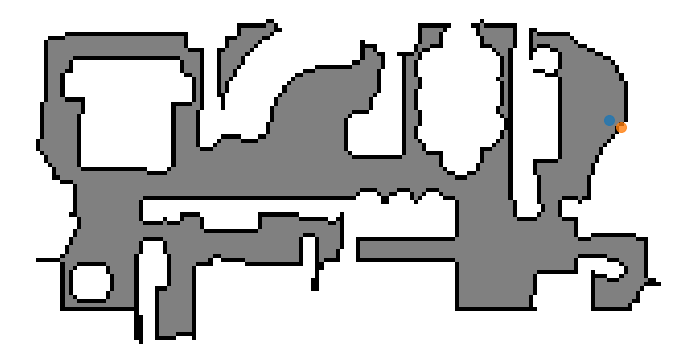

In [15]:
# @markdown ## Querying the NavMesh

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    # @markdown NavMesh area and bounding box can be queried via *navigable_area* and *get_bounds* respectively.
    print("NavMesh area = " + str(sim.pathfinder.navigable_area))
    print("Bounds = " + str(sim.pathfinder.get_bounds()))

    # @markdown A random point on the NavMesh can be queried with *get_random_navigable_point*.
    pathfinder_seed = 1  # @param {type:"integer"}
    sim.pathfinder.seed(pathfinder_seed)
    nav_point = sim.pathfinder.get_random_navigable_point()
    print("Random navigable point : " + str(nav_point))
    print("Is point navigable? " + str(sim.pathfinder.is_navigable(nav_point)))

    # @markdown The radius of the minimum containing circle (with vertex centroid origin) for the isolated navigable island of a point can be queried with *island_radius*.
    # @markdown This is analogous to the size of the point's connected component and can be used to check that a queried navigable point is on an interesting surface (e.g. the floor), rather than a small surface (e.g. a table-top).
    print("Nav island radius : " + str(sim.pathfinder.island_radius(nav_point)))

    # @markdown The closest boundary point can also be queried (within some radius).
    max_search_radius = 2.0  # @param {type:"number"}
    print(
        "Distance to obstacle: "
        + str(sim.pathfinder.distance_to_closest_obstacle(nav_point, max_search_radius))
    )
    hit_record = sim.pathfinder.closest_obstacle_surface_point(
        nav_point, max_search_radius
    )
    print("Closest obstacle HitRecord:")
    print(" point: " + str(hit_record.hit_pos))
    print(" normal: " + str(hit_record.hit_normal))
    print(" distance: " + str(hit_record.hit_dist))

    vis_points = [nav_point]

    # HitRecord will have infinite distance if no valid point was found:
    if math.isinf(hit_record.hit_dist):
        print("No obstacle found within search radius.")
    else:
        # @markdown Points near the boundary or above the NavMesh can be snapped onto it.
        perturbed_point = hit_record.hit_pos - hit_record.hit_normal * 0.2
        print("Perturbed point : " + str(perturbed_point))
        print(
            "Is point navigable? " + str(sim.pathfinder.is_navigable(perturbed_point))
        )
        snapped_point = sim.pathfinder.snap_point(perturbed_point)
        print("Snapped point : " + str(snapped_point))
        print("Is point navigable? " + str(sim.pathfinder.is_navigable(snapped_point)))
        vis_points.append(snapped_point)

    # @markdown ---
    # @markdown ### Visualization
    # @markdown Running this cell generates a topdown visualization of the NavMesh with sampled points overlayed.
    meters_per_pixel = 0.1  # @param {type:"slider", min:0.01, max:1.0, step:0.01}

    if display:
        xy_vis_points = convert_points_to_topdown(
            sim.pathfinder, vis_points, meters_per_pixel
        )
        # use the y coordinate of the sampled nav_point for the map height slice
        top_down_map = maps.get_topdown_map(
            sim.pathfinder, height=nav_point[1], meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        top_down_map = recolor_map[top_down_map]
        print("\nDisplay the map with key_point overlay:")
        display_map(top_down_map, key_points=xy_vis_points)

found_path : True
geodesic_distance : 11.360601425170898
path_points : [array([-8.606648 ,  0.072447 , -4.4369855], dtype=float32), array([-7.49344  ,  0.072447 , -4.1920214], dtype=float32), array([-7.39344 ,  0.072447, -4.142021], dtype=float32), array([-7.14344 ,  0.072447, -3.742021], dtype=float32), array([-6.94344 ,  0.072447, -2.042021], dtype=float32), array([-6.79344  ,  0.072447 , -1.9920211], dtype=float32), array([-1.1434402,  0.072447 , -0.9420209], dtype=float32), array([-0.7434397,  0.072447 , -0.7920213], dtype=float32), array([-0.6934395,  0.072447 , -0.6920209], dtype=float32), array([-0.6934395 ,  0.072447  ,  0.10797882], dtype=float32), array([-0.79343987,  0.072447  ,  0.20797873], dtype=float32), array([-1.2815362 ,  0.072447  ,  0.43957818], dtype=float32)]

Display the map with agent and path overlay:


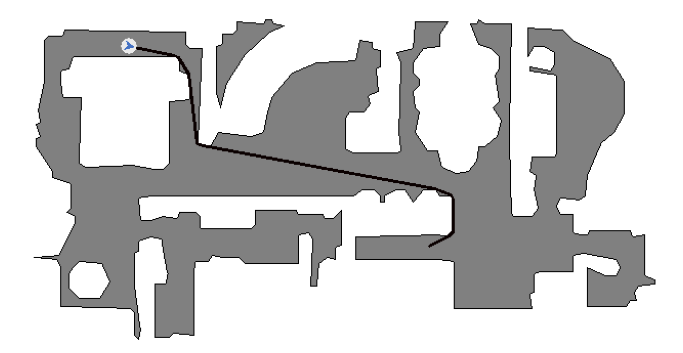

Rendering observations at path points:


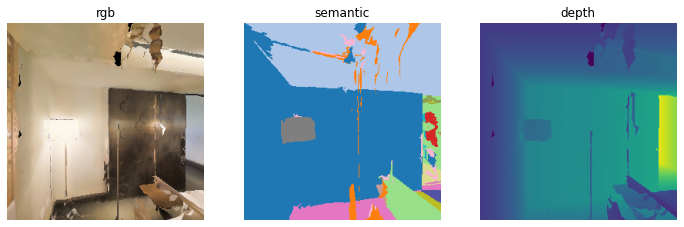

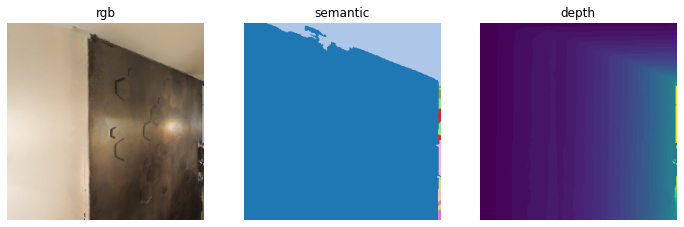

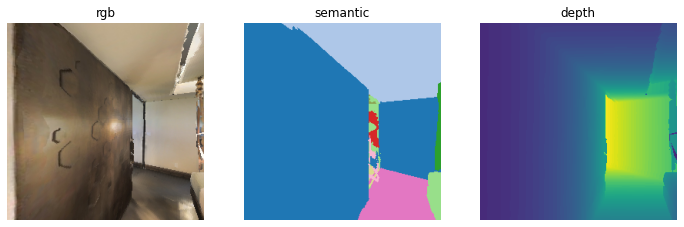

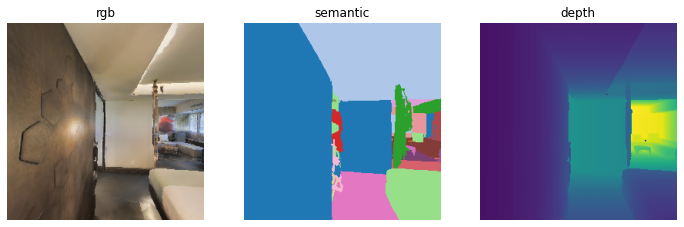

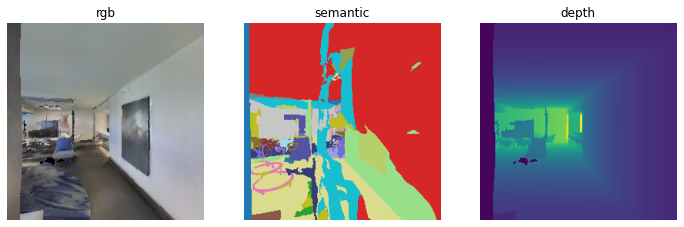

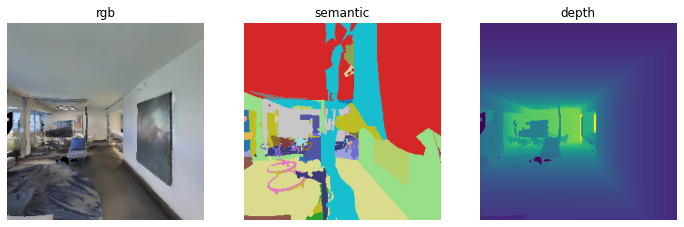

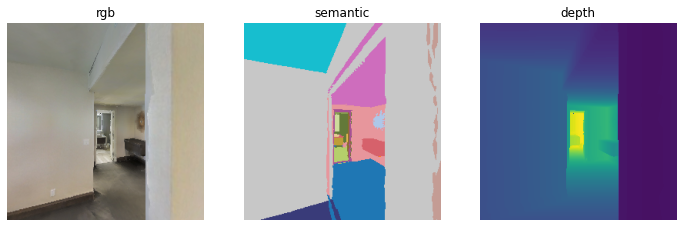

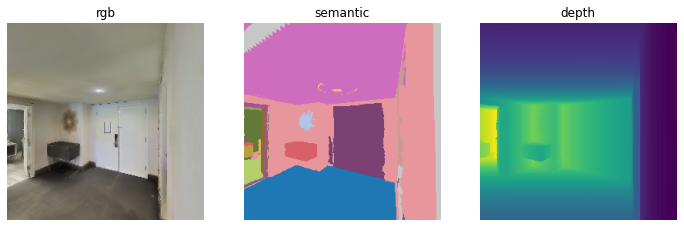

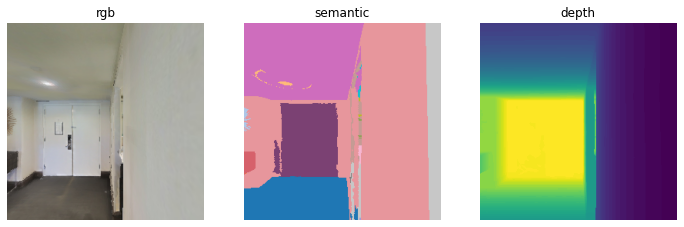

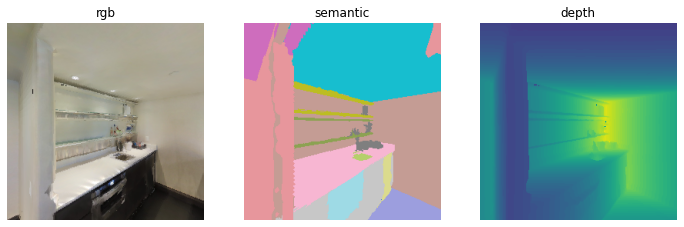

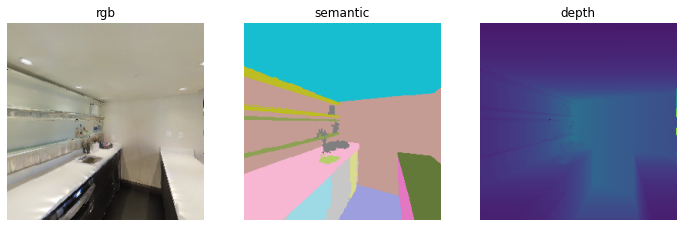

In [16]:
# @markdown ## Pathfinding Queries on NavMesh

# @markdown The shortest path between valid points on the NavMesh can be queried as shown in this example.

# @markdown With a valid PathFinder instance:
if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    seed = 4  # @param {type:"integer"}
    sim.pathfinder.seed(seed)

    # fmt off
    # @markdown 1. Sample valid points on the NavMesh for agent spawn location and pathfinding goal.
    # fmt on
    sample1 = sim.pathfinder.get_random_navigable_point()
    sample2 = sim.pathfinder.get_random_navigable_point()

    # @markdown 2. Use ShortestPath module to compute path between samples.
    path = habitat_sim.ShortestPath()
    path.requested_start = sample1
    path.requested_end = sample2
    found_path = sim.pathfinder.find_path(path)
    geodesic_distance = path.geodesic_distance
    path_points = path.points
    # @markdown - Success, geodesic path length, and 3D points can be queried.
    print("found_path : " + str(found_path))
    print("geodesic_distance : " + str(geodesic_distance))
    print("path_points : " + str(path_points))

    # @markdown 3. Display trajectory (if found) on a topdown map of ground floor
    if found_path:
        meters_per_pixel = 0.025
        scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb
        height = scene_bb.y().min
        if display:
            top_down_map = maps.get_topdown_map(
                sim.pathfinder, height, meters_per_pixel=meters_per_pixel
            )
            recolor_map = np.array(
                [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
            )
            top_down_map = recolor_map[top_down_map]
            grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
            # convert world trajectory points to maps module grid points
            trajectory = [
                maps.to_grid(
                    path_point[2],
                    path_point[0],
                    grid_dimensions,
                    pathfinder=sim.pathfinder,
                )
                for path_point in path_points
            ]
            grid_tangent = mn.Vector2(
                trajectory[1][1] - trajectory[0][1], trajectory[1][0] - trajectory[0][0]
            )
            path_initial_tangent = grid_tangent / grid_tangent.length()
            initial_angle = math.atan2(path_initial_tangent[0], path_initial_tangent[1])
            # draw the agent and trajectory on the map
            maps.draw_path(top_down_map, trajectory)
            maps.draw_agent(
                top_down_map, trajectory[0], initial_angle, agent_radius_px=8
            )
            print("\nDisplay the map with agent and path overlay:")
            display_map(top_down_map)

        # @markdown 4. (optional) Place agent and render images at trajectory points (if found).
        display_path_agent_renders = True  # @param{type:"boolean"}
        if display_path_agent_renders:
            print("Rendering observations at path points:")
            tangent = path_points[1] - path_points[0]
            agent_state = habitat_sim.AgentState()
            for ix, point in enumerate(path_points):
                if ix < len(path_points) - 1:
                    tangent = path_points[ix + 1] - point
                    agent_state.position = point
                    tangent_orientation_matrix = mn.Matrix4.look_at(
                        point, point + tangent, np.array([0, 1.0, 0])
                    )
                    tangent_orientation_q = mn.Quaternion.from_matrix(
                        tangent_orientation_matrix.rotation()
                    )
                    agent_state.rotation = utils.quat_from_magnum(tangent_orientation_q)
                    agent.set_state(agent_state)

                    observations = sim.get_sensor_observations()
                    rgb = observations["color_sensor"]
                    semantic = observations["semantic_sensor"]
                    depth = observations["depth_sensor"]

                    if display:
                        display_sample(rgb, semantic, depth)

## Loading a NavMesh for a scene:


To load a pre-computed NavMesh for a scene, simply include it with the scene asset you are loading using the `.navmesh` file-ending.

E.g.
```
habitat-test-scenes/
    apartment_1.glb
    apartment_1.navmesh
```



In [ ]:
# initialize a new simulator with the apartment_1 scene
# this will automatically load the accompanying .navmesh file
sim_settings["scene"] = "./data/scene_datasets/habitat-test-scenes/apartment_1.glb"
cfg = make_cfg(sim_settings)
try:  # Got to make initialization idiot proof
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

# the navmesh can also be explicitly loaded
sim.pathfinder.load_nav_mesh(
    "./data/scene_datasets/habitat-test-scenes/apartment_1.navmesh"
)

## Recompute the NavMesh at runtime

When computing the NavMesh at runtime, configuration options are available to customize the result based on the intended use case.

These settings include (all quantities in world units):
- **Voxelization parameters**:

  *Decrease these for better accuracy at the cost of higher compute cost.*

  **Note:** most continuous parameters are converted to multiples of cell dimensions, so these should be compatible values for best accuracy.
  - **cell_size** - xz-plane voxel dimensions. [Limit: >= 0]
  - **cell_height** - y-axis voxel dimension. [Limit: >= 0]

- **Agent parameters**:

  - **agent_height** - Height of the agent. Used to cull navigable cells with obstructions.
  - **agent_radius** - Radius of the agent. Used as distance to erode/shrink the computed heightfield. [Limit: >=0]
  - **agent_max_climb** - Maximum ledge height that is considered to still be traversable. [Limit: >=0]
  - **agent_max_slope** - The maximum slope that is considered navigable. [Limits: 0 <= value < 85] [Units: Degrees]

- **Navigable area filtering options** (default active):
  - **filter_low_hanging_obstacles** - Marks navigable spans as non-navigable if the clearence above the span is less than the specified height.
  - **filter_ledge_spans** - Marks spans that are ledges as non-navigable. This filter reduces the impact of the overestimation of conservative voxelization so the resulting mesh will not have regions hanging in the air over ledges.
  - **filter_walkable_low_height_spans** - Marks navigable spans as non-navigable if the clearence above the span is less than the specified height. Allows the formation of navigable regions that will flow over low lying objects such as curbs, and up structures such as stairways.

- **Detail mesh generation parameters**:
  - **region_min_size** - Minimum number of cells allowed to form isolated island areas.
  - **region_merge_size** - Any 2-D regions with a smaller span (cell count) will, if possible, be merged with larger regions. [Limit: >=0]
  - **edge_max_len** - The maximum allowed length for contour edges along the border of the mesh. Extra vertices will be inserted as needed to keep contour edges below this length. A value of zero effectively disables this feature. [Limit: >=0] [ / cell_size]
  - **edge_max_error** - The maximum distance a simplfied contour's border edges should deviate the original raw contour. [Limit: >=0]
  - **verts_per_poly** - The maximum number of vertices allowed for polygons generated during the contour to polygon conversion process.[Limit: >= 3]
  - **detail_sample_dist** - Sets the sampling distance to use when generating the detail mesh. (For height detail only.) [Limits: 0 or >= 0.9] [x cell_size]
  - **detail_sample_max_error** - The maximum distance the detail mesh surface should deviate from heightfield data. (For height detail only.) [Limit: >=0] [x cell_height]





Successfully snapped point to: [0.         0.07244661 0.        ]
Agent state: AgentState(position=array([0.        , 0.07244661, 0.        ], dtype=float32), rotation=quaternion(0.7109135389328, -0, -0.703279376029968, -0), velocity=array([0., 0., 0.]), angular_velocity=array([0., 0., 0.]), force=array([0., 0., 0.]), torque=array([0., 0., 0.]), sensor_states={'color_sensor': SixDOFPose(position=array([0.       , 1.5724466, 0.       ], dtype=float32), rotation=quaternion(0.7109135389328, 0, -0.703279376029968, 0)), 'depth_sensor': SixDOFPose(position=array([0.       , 1.5724466, 0.       ], dtype=float32), rotation=quaternion(0.7109135389328, 0, -0.703279376029968, 0)), 'semantic_sensor': SixDOFPose(position=array([0.       , 1.5724466, 0.       ], dtype=float32), rotation=quaternion(0.7109135389328, 0, -0.703279376029968, 0))})
 position = [0.         0.07244661 0.        ]
 rotation = quaternion(0.7109135389328, -0, -0.703279376029968, -0)
 orientation (about Y) = 1.56


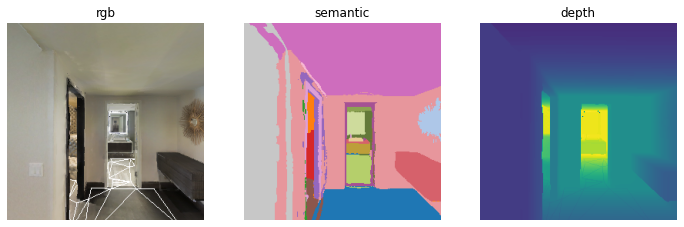


Display topdown map with agent:


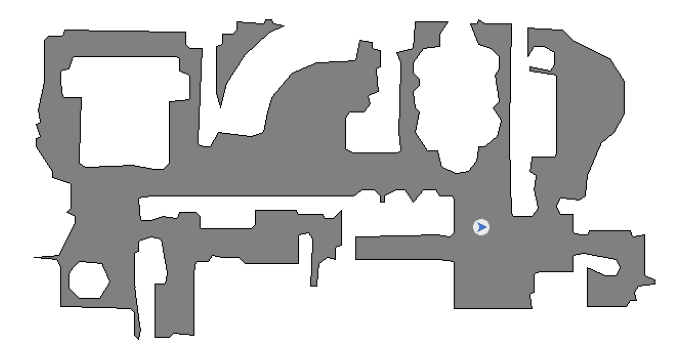

In [17]:
# @markdown ## Recompute NavMesh:

# @markdown Take a moment to edit some parameters and visualize the resulting NavMesh. Consider agent_radius and agent_height as the most impactful starting point. Note that large variations from the defaults for these parameters (e.g. in the case of very small agents) may be better supported by additional changes to cell_size and cell_height.
navmesh_settings = habitat_sim.NavMeshSettings()

# @markdown Choose Habitat-sim defaults (e.g. for point-nav tasks), or custom settings.
use_custom_settings = False  # @param {type:"boolean"}
sim.navmesh_visualization = True  # @param {type:"boolean"}
navmesh_settings.set_defaults()
if use_custom_settings:
    # fmt: off
    #@markdown ---
    #@markdown ## Configure custom settings (if use_custom_settings):
    #@markdown Configure the following NavMeshSettings for customized NavMesh recomputation.
    #@markdown **Voxelization parameters**:
    navmesh_settings.cell_size = 0.05 #@param {type:"slider", min:0.01, max:0.2, step:0.01}
    #default = 0.05
    navmesh_settings.cell_height = 0.2 #@param {type:"slider", min:0.01, max:0.4, step:0.01}
    #default = 0.2

    #@markdown **Agent parameters**:
    navmesh_settings.agent_height = 1.5 #@param {type:"slider", min:0.01, max:3.0, step:0.01}
    #default = 1.5
    navmesh_settings.agent_radius = 0.1 #@param {type:"slider", min:0.01, max:0.5, step:0.01}
    #default = 0.1
    navmesh_settings.agent_max_climb = 0.2 #@param {type:"slider", min:0.01, max:0.5, step:0.01}
    #default = 0.2
    navmesh_settings.agent_max_slope = 45 #@param {type:"slider", min:0, max:85, step:1.0}
    # default = 45.0
    # fmt: on
    # @markdown **Navigable area filtering options**:
    navmesh_settings.filter_low_hanging_obstacles = True  # @param {type:"boolean"}
    # default = True
    navmesh_settings.filter_ledge_spans = True  # @param {type:"boolean"}
    # default = True
    navmesh_settings.filter_walkable_low_height_spans = True  # @param {type:"boolean"}
    # default = True

    # fmt: off
    #@markdown **Detail mesh generation parameters**:
    #@markdown For more details on the effects
    navmesh_settings.region_min_size = 20 #@param {type:"slider", min:0, max:50, step:1}
    #default = 20
    navmesh_settings.region_merge_size = 20 #@param {type:"slider", min:0, max:50, step:1}
    #default = 20
    navmesh_settings.edge_max_len = 12.0 #@param {type:"slider", min:0, max:50, step:1}
    #default = 12.0
    navmesh_settings.edge_max_error = 1.3 #@param {type:"slider", min:0, max:5, step:0.1}
    #default = 1.3
    navmesh_settings.verts_per_poly = 6.0 #@param {type:"slider", min:3, max:6, step:1}
    #default = 6.0
    navmesh_settings.detail_sample_dist = 6.0 #@param {type:"slider", min:0, max:10.0, step:0.1}
    #default = 6.0
    navmesh_settings.detail_sample_max_error = 1.0 #@param {type:"slider", min:0, max:10.0, step:0.1}
    # default = 1.0
    # fmt: on

navmesh_success = sim.recompute_navmesh(
    sim.pathfinder, navmesh_settings, include_static_objects=False
)

if not navmesh_success:
    print("Failed to build the navmesh! Try different parameters?")
else:
    # @markdown ---
    # @markdown **Agent parameters**:

    agent_state = sim.agents[0].get_state()
    set_random_valid_state = False  # @param {type:"boolean"}
    seed = 5  # @param {type:"integer"}
    sim.seed(seed)
    orientation = 0
    if set_random_valid_state:
        agent_state.position = sim.pathfinder.get_random_navigable_point()
        orientation = random.random() * math.pi * 2.0
    # @markdown Optionally configure the agent state (overrides random state):
    set_agent_state = True  # @param {type:"boolean"}
    try_to_make_valid = True  # @param {type:"boolean"}
    if set_agent_state:
        pos_x = 0  # @param {type:"number"}
        pos_y = 0  # @param {type:"number"}
        pos_z = 0.0  # @param {type:"number"}
        # @markdown Y axis rotation (radians):
        orientation = 1.56  # @param {type:"number"}
        agent_state.position = np.array([pos_x, pos_y, pos_z])
        if try_to_make_valid:
            snapped_point = np.array(sim.pathfinder.snap_point(agent_state.position))
            if not np.isnan(np.sum(snapped_point)):
                print("Successfully snapped point to: " + str(snapped_point))
                agent_state.position = snapped_point
    if set_agent_state or set_random_valid_state:
        agent_state.rotation = utils.quat_from_magnum(
            mn.Quaternion.rotation(-mn.Rad(orientation), mn.Vector3(0, 1.0, 0))
        )
        sim.agents[0].set_state(agent_state)

    agent_state = sim.agents[0].get_state()
    print("Agent state: " + str(agent_state))
    print(" position = " + str(agent_state.position))
    print(" rotation = " + str(agent_state.rotation))
    print(" orientation (about Y) = " + str(orientation))

    observations = sim.get_sensor_observations()
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    depth = observations["depth_sensor"]

    if display:
        display_sample(rgb, semantic, depth)
        # @markdown **Map parameters**:
        # fmt: off
        meters_per_pixel = 0.025  # @param {type:"slider", min:0.01, max:0.1, step:0.005}
        # fmt: on
        agent_pos = agent_state.position
        # topdown map at agent position
        top_down_map = maps.get_topdown_map(
            sim.pathfinder, height=agent_pos[1], meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        top_down_map = recolor_map[top_down_map]
        grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
        # convert world agent position to maps module grid point
        agent_grid_pos = maps.to_grid(
            agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder
        )
        agent_forward = utils.quat_to_magnum(
            sim.agents[0].get_state().rotation
        ).transform_vector(mn.Vector3(0, 0, -1.0))
        agent_orientation = math.atan2(agent_forward[0], agent_forward[2])
        # draw the agent and trajectory on the map
        maps.draw_agent(
            top_down_map, agent_grid_pos, agent_orientation, agent_radius_px=8
        )
        print("\nDisplay topdown map with agent:")
        display_map(top_down_map)

In [ ]:
# @markdown ##Saving the NavMesh

# fmt: off
# @markdown An existing NavMesh can be saved with *Pathfinder.save_nav_mesh(filename)*
if sim.pathfinder.is_loaded:
    navmesh_save_path = "/content/habitat-sim/data/test_saving.navmesh" #@param {type:"string"}
    sim.pathfinder.save_nav_mesh(navmesh_save_path)
    print('Saved NavMesh to "' + navmesh_save_path + '"')
    sim.pathfinder.load_nav_mesh(navmesh_save_path)
# fmt: on

Taking# Taking Actions on the NavMesh:

The following example demonstrates taking random agent actions on the NavMesh. Both continuous and discrete action spaces are available. Sliding vs. non-sliding scenarios are compared.

## What is sliding?
Most game engines allow agents to slide along obstacles when commanding actions which collide with the environment. While this is a reasonable behavior in games, it does not accuractely reflect the result of collisions between robotic agents and the environment.

We note that **allowing sliding** makes training easier and results in higher simulation performance, but **hurts sim-2-real transfer** of trained policies.

For a more detailed exposition of this subject see our paper:
["Are We Making Real Progress in Simulated Environments? Measuring the Sim2Real Gap in Embodied Visual Navigation"](https://arxiv.org/abs/1912.06321).


In [18]:
# @title Discrete and Continuous Navigation:

# @markdown Take moment to run this cell a couple times and note the differences between discrete and continuous navigation with and without sliding.

# @markdown ---
# @markdown ### Set example parameters:
seed = 7  # @param {type:"integer"}
# @markdown Optionally navigate on the currently configured scene and NavMesh instead of re-loading with defaults:
use_current_scene = False  # @param {type:"boolean"}


sim_settings["seed"] = seed
if not use_current_scene:
    # reload a default nav scene
    sim_settings[
        "scene"
    ] = "/home/carlos/repositorios/habitat-sim/data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"
    cfg = make_cfg(sim_settings)
    try:  # make initialization Colab cell order proof
        sim.close()
    except NameError:
        pass
    sim = habitat_sim.Simulator(cfg)
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])
# set new initial state
sim.initialize_agent(agent_id=0)
agent = sim.agents[0]

# @markdown Seconds to simulate:
sim_time = 10  # @param {type:"integer"}

# @markdown Optional continuous action space parameters:
continuous_nav = True  # @param {type:"boolean"}

# defaults for discrete control
# control frequency (actions/sec):
control_frequency = 3
# observation/integration frames per action
frame_skip = 1
if continuous_nav:
    control_frequency = 5  # @param {type:"slider", min:1, max:30, step:1}
    frame_skip = 12  # @param {type:"slider", min:1, max:30, step:1}


fps = control_frequency * frame_skip
print("fps = " + str(fps))
control_sequence = []
for _action in range(int(sim_time * control_frequency)):
    if continuous_nav:
        # allow forward velocity and y rotation to vary
        control_sequence.append(
            {
                "forward_velocity": random.random() * 2.0,  # [0,2)
                "rotation_velocity": (random.random() - 0.5) * 2.0,  # [-1,1)
            }
        )
    else:
        control_sequence.append(random.choice(action_names))

# create and configure a new VelocityControl structure
vel_control = habitat_sim.physics.VelocityControl()
vel_control.controlling_lin_vel = True
vel_control.lin_vel_is_local = True
vel_control.controlling_ang_vel = True
vel_control.ang_vel_is_local = True

# try 2 variations of the control experiment
for iteration in range(2):
    # reset observations and robot state
    observations = []

    video_prefix = "nav_sliding"
    sim.config.sim_cfg.allow_sliding = True
    # turn sliding off for the 2nd pass
    if iteration == 1:
        sim.config.sim_cfg.allow_sliding = False
        video_prefix = "nav_no_sliding"

    print(video_prefix)

    # manually control the object's kinematic state via velocity integration
    time_step = 1.0 / (frame_skip * control_frequency)
    print("time_step = " + str(time_step))
    for action in control_sequence:

        # apply actions
        if continuous_nav:
            # update the velocity control
            # local forward is -z
            vel_control.linear_velocity = np.array([0, 0, -action["forward_velocity"]])
            # local up is y
            vel_control.angular_velocity = np.array([0, action["rotation_velocity"], 0])

        else:  # discrete action navigation
            discrete_action = agent.agent_config.action_space[action]

            did_collide = False
            if agent.controls.is_body_action(discrete_action.name):
                did_collide = agent.controls.action(
                    agent.scene_node,
                    discrete_action.name,
                    discrete_action.actuation,
                    apply_filter=True,
                )
            else:
                for _, v in agent._sensors.items():
                    habitat_sim.errors.assert_obj_valid(v)
                    agent.controls.action(
                        v.object,
                        discrete_action.name,
                        discrete_action.actuation,
                        apply_filter=False,
                    )

        # simulate and collect frames
        for _frame in range(frame_skip):
            if continuous_nav:
                # Integrate the velocity and apply the transform.
                # Note: this can be done at a higher frequency for more accuracy
                agent_state = agent.state
                previous_rigid_state = habitat_sim.RigidState(
                    utils.quat_to_magnum(agent_state.rotation), agent_state.position
                )

                # manually integrate the rigid state
                target_rigid_state = vel_control.integrate_transform(
                    time_step, previous_rigid_state
                )

                # snap rigid state to navmesh and set state to object/agent
                # calls pathfinder.try_step or self.pathfinder.try_step_no_sliding
                end_pos = sim.step_filter(
                    previous_rigid_state.translation, target_rigid_state.translation
                )

                # set the computed state
                agent_state.position = end_pos
                agent_state.rotation = utils.quat_from_magnum(
                    target_rigid_state.rotation
                )
                agent.set_state(agent_state)

                # Check if a collision occured
                dist_moved_before_filter = (
                    target_rigid_state.translation - previous_rigid_state.translation
                ).dot()
                dist_moved_after_filter = (
                    end_pos - previous_rigid_state.translation
                ).dot()

                # NB: There are some cases where ||filter_end - end_pos|| > 0 when a
                # collision _didn't_ happen. One such case is going up stairs.  Instead,
                # we check to see if the the amount moved after the application of the filter
                # is _less_ than the amount moved before the application of the filter
                EPS = 1e-5
                collided = (dist_moved_after_filter + EPS) < dist_moved_before_filter

            # run any dynamics simulation
            sim.step_physics(time_step)

            # render observation
            observations.append(sim.get_sensor_observations())

    print("frames = " + str(len(observations)))
    # video rendering with embedded 1st person view
    if True:
        # use the vieo utility to render the observations
        vut.make_video(
            observations=observations,
            primary_obs="color_sensor",
            primary_obs_type="color",
            video_file=output_path + "continuous_nav",
            fps=fps,
            open_vid=True,
        )

    sim.reset()

# [/embodied_agent_navmesh]

I0126 14:31:59.840615 1765 simulator.py:221] Loaded navmesh /home/carlos/repositorios/habitat-sim/data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.navmesh


fps = 60
nav_sliding
time_step = 0.016666666666666666
frames = 600
Encoding the video: ./data/continuous_nav.mp4 


nav_no_sliding
time_step = 0.016666666666666666
frames = 600
Encoding the video: ./data/continuous_nav.mp4 
